# Investigating High Traffic Indicators on Westbound I-94

This project takes a deeper analysis of the traffic patterns of interstate 94 in connection to some key factors, such as:
* Weather types and conditions, including the amount of rain, cloud, and snow.
* Time of the day, week, month, etc.
* Temperature.
* U.S. Holidays.

The ***I-94*** is one of the longest U.S. interstate, streching ***1,585 miles*** along ***east-west*** from Billings, Montana, to Port Huron, Michigan. In deciding the project's **purpose**, we took into consideration the following factors that make I-94's traffic analysis particularly valuable for improving the overall safety and efficiency in the highway: 
* I-94 connects to near ***seven major cities***, including Minneapolis-St. Paul in Minnesota, Milwaukee in Wisconsin, and Chicago in Illinois, making it a vital transportation artery in the Midwest.
* It's economic impact on faciliatating the ***movement of goods*** and people between major population centers, industrial hubs, and distribution centers. 
* Notorious traffic volume between the Twin Cities (Minneapolis and St. Paul).

A **use case** of the analysis could be better understanding of what a normal range for traffic volume looks like for I-94, more accurately predict heavy traffic conditions, and plan beforehand for such situations based on the indicators to avoid any mishaps.

# Finding the Right Dataset
For this analysis, we found  the [dataset](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume) collected by John Hogue in the UC Irvine Machine Learning Repository that provides hourly ***Mineapolis to St. Paul*** traffic details from ***2012 - 2014/18?***. This dataset has a comprehensive record of indicators useful to our analysis.

Because the dataset found only covers Mineapolis to St. Paul traffic going **east to west**, we will focus the findings of our analysis to **I-94 Westbound** traffic in order to avoid generalization. This segment of I-94 is also notoriously known for its high traffic volume. Therefore, the dataset seems to be a good fit without detering too far from the original goal.

<center><img src=".\images\i94_map.jpg" alt="I-94 Map" width="500" height="300"></center>

In [358]:
# Import the data
import pandas as pd

i94_traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', encoding='latin1')
i94_traffic.head(3)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767


In [359]:
i94_traffic.tail(3)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [360]:
i94_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


### Initial Observations

* ***48204*** entries and ***9*** columns.
* Type correction is needed for `date_time` for accurate time-based analysis. The rest of the data types seem consistent with the Hogue's [documentation](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume) for the dataset.
* `holiday` has only ***61 non-null*** values where most of them seem to be ***NaN*** values at a glance. According to the original [dataset](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume), there should have no missing data for this column. We'll be taking a closer look at the `holiday` column to identify the issue.

In [361]:
# Analyzing the holiday column for NaN values
i94_traffic['holiday'].value_counts(dropna=False)

holiday
NaN                          48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: count, dtype: int64

After checking the original [CSV file](https://archive.ics.uci.edu/static/public/492/metro+interstate+traffic+volume.zip) using `COUNTIF`, the fields where no holidays take place have exactly ***48143*** ***"None"*** entries. This explains why ***48143*** entries are `NaN` as `pandas` probably interepreted `None` as missing values while importing the dataset.

## Cleaning and Prepping the Dataset for a Meaninful Analysis

1. Replace the `NaN` missing values. In this case, it would be accurate to replace the NaN values with the string ***"None"***.
2. Correct the `dtype` for `date_time` column for meaningful time-based analysis.
3. Check for unexpected values in the *categorical* columns. We'll look at the *numerical* columns for outliers during the analysis stage on as needed basis. We'll look for any outliers in the *numerical* columns: `temp`, `snow_1h`, `rain_1h`, `clouds_all`, `date_time`, and `traffic_volume`.

### 1. Replace the NaN missing values with "None":

In [362]:
# Replace the missing values in the holiday column with "None"
i94_traffic['holiday'] = i94_traffic['holiday'].fillna("None")

# Validate changes
i94_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


All ***48204*** entries are non-null.

### 2. Convert the date column to a datetime object for time-based analysis:

In [363]:
# Get the current data type for the date_time column 
i94_traffic['date_time'].dtype

dtype('O')

In [364]:
# Convert the date_time column from 'object' to a 'datetime' object
i94_traffic['date_time'] = pd.to_datetime(i94_traffic['date_time'])

i94_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              48204 non-null  object        
 1   temp                 48204 non-null  float64       
 2   rain_1h              48204 non-null  float64       
 3   snow_1h              48204 non-null  float64       
 4   clouds_all           48204 non-null  int64         
 5   weather_main         48204 non-null  object        
 6   weather_description  48204 non-null  object        
 7   date_time            48204 non-null  datetime64[ns]
 8   traffic_volume       48204 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.3+ MB


`date_time` column is now of *datetime64[ns]* type.

### 3. Check for unexpected values in the Categorical Columns or Outliers in Numerical Columns:

We start by checking the *categorical* data to ensure the values are relevant and get of rid of any unexpected values.

In [365]:
i94_traffic['weather_main'].value_counts()

weather_main
Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: count, dtype: int64

>>i94_traffic['weather_description'].value_counts()

>>i94_traffic['weather_description'].str.extract(pattern)

We could potentially extract severity levels of each weather type from the weather description. For now, we'll keep this in the back burner since we're not sure if it's relevant to the analysis and how much value it will provide yet.

We noticed a discrepency in the `rain_1h` column. There is one value between (8848.17, 9831.3] that is different from the rest of the entries. Infact, it is z-szore away from the standard deviation. This value is too high for hourly rainfall record and is likely caused by a system error. Inorder to prevent the value from distorting the analysis, we'll change it to 0.0 (no rainfall).

In [366]:
# Check the rain column
i94_traffic['rain_1h'].value_counts(bins = 10).sort_index()

(-9.831999999999999, 983.13]    48203
(983.13, 1966.26]                   0
(1966.26, 2949.39]                  0
(2949.39, 3932.52]                  0
(3932.52, 4915.65]                  0
(4915.65, 5898.78]                  0
(5898.78, 6881.91]                  0
(6881.91, 7865.04]                  0
(7865.04, 8848.17]                  0
(8848.17, 9831.3]                   1
Name: count, dtype: int64

In [367]:
# Replace rain column where rain volume in a hour is greater than 1000
i94_traffic.loc[i94_traffic['rain_1h'] > 1000, 'rain_1h'] = 0.00
i94_traffic['rain_1h'].value_counts(bins = 10).sort_index()

(-0.0566, 5.563]    47928
(5.563, 11.126]       201
(11.126, 16.689]       42
(16.689, 22.252]       16
(22.252, 27.815]       12
(27.815, 33.378]        3
(33.378, 38.941]        0
(38.941, 44.504]        1
(44.504, 50.067]        0
(50.067, 55.63]         1
Name: count, dtype: int64

We see a more accurate distribution of rain volume after removing the outlier. 

All the other columns, including  `snow_1h`, `clouds_all`, `date_time`, `temp`, seem to be consistent and represent accurate data. The process will be eleiminated from the report to save space.

## Exploration: Finding Patterns in the Traffic Volume

We'll now explore the distribution of a few columns for our analysis and also keep an eye for any ***outliers*** in the *numerical* columns: `temp`, `snow_1h`, `rain_1h`, `clouds_all`, `date_time`, and `traffic_volume`.

We'll try to find any patterns in the traffic volume. We'll look at a few things:

1. Distribution of traffic volume. We'll pursue any leads to our investigation.
2. Time-based analysis of traffic by hour, week, month, etc. as well as differences in business days vs. weekend traffic. 
3. Can we derive any relaible correlations between traffic volume and weather, holidays, and temperature indicators? We'll pursue strong correlations further in our investigation.

### Understanding the Distribution of Traffic Volume

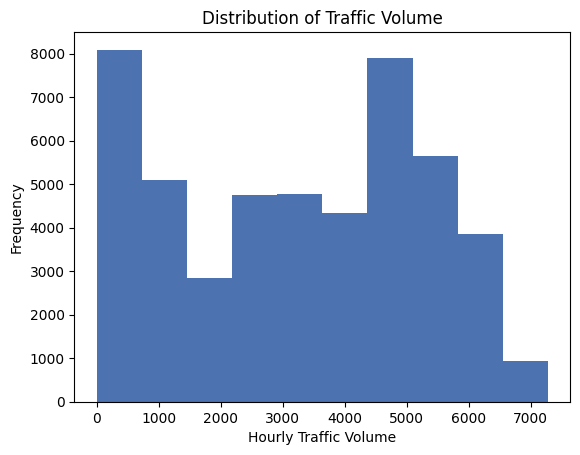

In [368]:
import matplotlib.pyplot as plt

# Add inline magic to generate matplotlib graphs in Jupyter Notebook
%matplotlib inline

traffic_vol = i94_traffic['traffic_volume']

# Visualize the distribution of traffic volume
traffic_vol.plot.hist(xlabel='Hourly Traffic Volume', title='Distribution of Traffic Volume')
plt.show()


In [369]:
# Generate key insights about Traffic Volume
traffic_vol.describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

**Quick Observations:**

* The traffic volume range from ***0 to 7280***, with the majority of the bulk distributed between ***0 - 500*** vehicles (8000 count) and ***4500 - 5000*** vehicles (8000 count), with an avergae of ***3,260*** vehicles.
* About ***25%*** of the time, there were ***1,193 or fewer*** vehicles each hour. One possibility is that this is mostly representative of nighttime traffic.
* In the ***75th percentile***, there were ***4,933 or fewer*** vechiles each hour. The rest of the 25%, the traffic exceeded 4,933 vehicles.

The possibility of varying nighttime vs. daytime traffic could give a different perspective to our analysis.

### Exploring Nighttime VS Daytime Traffic Comparisions

**Isolating the dataset:** Below, we seggregated the dataset into two parts:
* Daytime data: hours from 7 a.m. to 7 p.m. (12 hours)
* Nighttime data: hours from 7 p.m. to 7 a.m. (12 hours)

*Note:* The `date_time` column has already been typed correctly in the cleaning stage to derive meaninful time-based analysis.

In [370]:
import datetime as dt

date_col = i94_traffic['date_time']

# Create a boolean for daytime data selection - [7:00:00. - 19:00:00).
daytime_bool = (date_col.dt.time >= dt.time(7, 0, 0)) & (date_col.dt.time < dt.time(19, 0, 0))

i94_traffic['time_of_day'] = ''
i94_traffic.loc[daytime_bool, 'time_of_day'] = 'Daytime'

# Verify the isolated daytime traffic dataframe
i94_traffic.loc[daytime_bool, 'date_time'].dt.time.value_counts().sort_index()

date_time
07:00:00    2079
08:00:00    2080
09:00:00    2018
10:00:00    2078
11:00:00    1952
12:00:00    1955
13:00:00    1905
14:00:00    1969
15:00:00    1934
16:00:00    1988
17:00:00    1933
18:00:00    1986
Name: count, dtype: int64

In [371]:
# Create a boolean for nighttime data selection - [00:00:00 - 7:00:00) and [19:00:00 - 23:00:00]
nighttime_bool = (date_col.dt.time >= dt.time(19, 0, 0)) | (date_col.dt.time < dt.time(7, 0, 0))

i94_traffic.loc[nighttime_bool, 'time_of_day'] = 'Nighttime'
i94_traffic.loc[nighttime_bool, 'date_time'].dt.time.value_counts().sort_index()

date_time
00:00:00    2037
01:00:00    2049
02:00:00    2019
03:00:00    2025
04:00:00    2091
05:00:00    2063
06:00:00    2087
19:00:00    1961
20:00:00    1979
21:00:00    1982
22:00:00    1994
23:00:00    2040
Name: count, dtype: int64

**Comparing the distributions of Nighttime VS Daytime traffic volume:**

<Figure size 2000x2500 with 0 Axes>

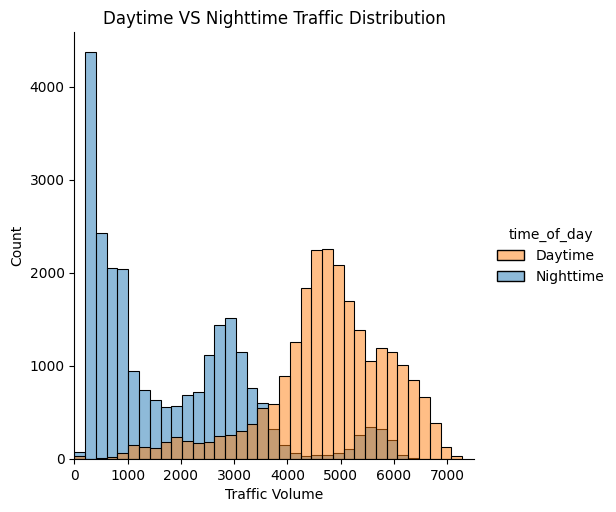

In [372]:
import seaborn as sns

# Get all colors from tab10 color palette
palette_colors = sns.color_palette('tab10')
color_map = {'Daytime': palette_colors[1], 
             'Nighttime': palette_colors[0]
            }

# Plot a grouped historgram to compare the two dataset's distributions
plt.figure(figsize=(20, 25))
sns.displot(data=i94_traffic, x="traffic_volume", hue="time_of_day", palette=color_map)

plt.title('Daytime VS Nighttime Traffic Distribution')
plt.xlabel('Traffic Volume')
plt.ylabel('Count')
plt.xlim(0, 7500)

plt.show()

In [373]:
# Generate Insights for Daytime traffic
i94_traffic.loc[daytime_bool, 'traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [374]:
# Generate Insights for Nighttime traffic
i94_traffic.loc[nighttime_bool, 'traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

**Observations:**

The Nighttime traffic has a ***right-skewed*** distribution with ***75%*** of the hourly traffic less than or equal to 2,819. On the other hand, the daytime traffic is almost ***normally distributed*** historgram with the majority of bulk located somewhere between 4,500 - 5000 and with ***50%*** of the time over 4,820 traffic per hour. The nightime traffic also only ranges between 0 to 6,386, much less in comparision to the daytime traffic ranging anywhere between 0 to 7,280 traffic volume.

Because the goal is to find indicators of *High* traffic, the daytime traffic distribution looks promising. Wel'll isolate the daytime traffic dataset and focus the analysis on it moving forward.

**Isolate Daytime Dataset to Conitnue Analysis on Daytime Traffic Only:**

In [375]:
# Isolate daytime traffic from the original dataset based on the daytime boolean criteria
daytime_traffic = i94_traffic.copy().loc[daytime_bool]

# Verify the isolated daytime traffic dataframe
daytime_traffic['date_time'].dt.time.value_counts().sort_index()

date_time
07:00:00    2079
08:00:00    2080
09:00:00    2018
10:00:00    2078
11:00:00    1952
12:00:00    1955
13:00:00    1905
14:00:00    1969
15:00:00    1934
16:00:00    1988
17:00:00    1933
18:00:00    1986
Name: count, dtype: int64

### Time-based Traffic Volume Traffic Indicators

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day. We're going to look at a few line plots showing how the traffic volume changed according to the following parameters:
 1. Month
 2. Day of the week
 3. Time of day

**1. Monthly Traffic Patterns**:

In [415]:
# Extract the month from date_time column
daytime_traffic['month'] = daytime_traffic['date_time'].dt.month

# Verify the month column data
daytime_traffic.loc[5000:7500,['date_time', 'month']]

,date_time,month
5000,2013-04-11 14:00:00,4
5001,2013-04-11 15:00:00,4
5002,2013-04-11 16:00:00,4
5003,2013-04-11 17:00:00,4
5004,2013-04-11 18:00:00,4
...,...,...
7496,2013-07-07 12:00:00,7
7497,2013-07-07 13:00:00,7
7498,2013-07-07 14:00:00,7
7499,2013-07-07 15:00:00,7


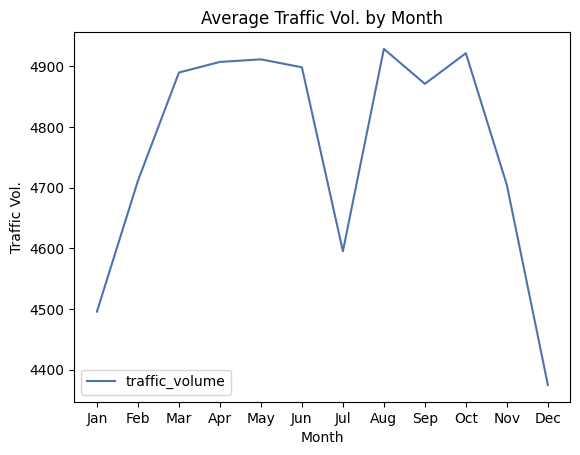

In [461]:
# Group dataset by month to get monthly traffic average/mean
mean_by_month = daytime_traffic.pivot_table(values='traffic_volume', index='month', aggfunc='mean')

mean_by_month['traffic_volume'].plot.line()

plt.xticks(mean_by_month.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.title('Average Traffic Vol. by Month')
plt.xlabel('Month')
plt.ylabel('Traffic Vol.')
#plt.axhline(daytime_traffic['traffic_volume'].mean(), label='Avg. traffic')
plt.legend()

plt.show()


**Observations:**

* The average traffic volume in the *winter months* (December, January, Feburary) are particularly lower, with the lowest traffic being in December.
* The avergae traffic colume in the *warmer months* are usually high.
* ***Exception:*** The average traffic takes a nose dive in *July*, one of the warmer months. Could there be other factors involved? We'll plot a yearly traffic trends for July to possibly get insights.

Text(0, 0.5, 'Traffic Vol.')

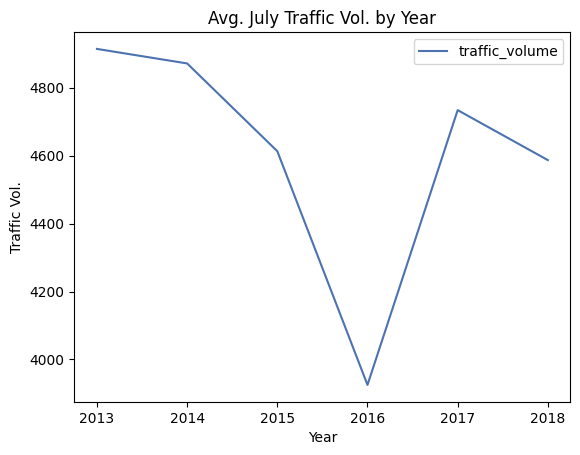

In [433]:
# Isolate July traffic data
july_traffic = daytime_traffic[daytime_traffic['month'] == 7]

# Extract the year from date_time column
daytime_traffic['year'] = daytime_traffic['date_time'].dt.year

# Get average yearly traffic volume
july_traffic.pivot_table(values='traffic_volume', index='year', aggfunc='mean').plot.line()

plt.title('Avg. July Traffic Vol. by Year')
plt.xlabel('Year')
plt.ylabel('Traffic Vol.')


Typically, the traffic is pretty heavy in July, similar to the other warm months. The only exception we see is 2016, which had a high decrease in traffic volume. One possible reason for this is road construction — this article from 2016 supports this hypothesis.

As a tentative conclusion here, we can say that warm months generally show heavier traffic compared to cold months. In a warm month, you can can expect for each hour of daytime a traffic volume close to 5,000 cars.

For some reason, the July traffic volume in the year 2016 takes a nose dive. Possibly, an external factors, such as constrution work in July 2016, could explain this unexpected result. 

What is the average traffic in warmer months excluding 2016 July data? This will likely be a good ballpark.

**2. Day of the Week Traffic Patterns**:

We'll now continue with building line plots for another time unit: day of the week.

In [438]:
# Extract day of the week from date_time column
daytime_traffic['dayofweek'] = daytime_traffic['date_time'].dt.dayofweek

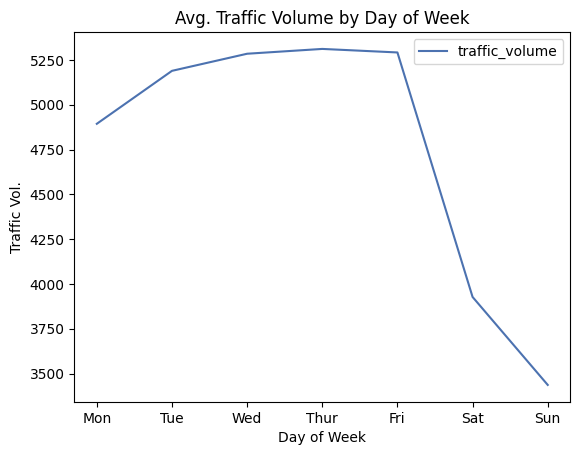

In [462]:
# Get traffic average/mean by day of week
mean_by_dayofweek = daytime_traffic.pivot_table(values='traffic_volume', index='dayofweek', aggfunc='mean')

# Plot a line graph
mean_by_dayofweek.plot.line(label='Average traffic')

plt.legend()
plt.title('Avg. Traffic Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Traffic Vol.')

# Customize the xticks
plt.xticks(mean_by_dayofweek.index, ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])

plt.show()

In [469]:
round(daytime_traffic['traffic_volume'].mean(), 0)

4762.0

**Observations:**

Typically, the avergae traffic volume is significantly heavier during the ***business days***, peaking on Friday. Traffic plunges on the ***weekend*** (Sat - Sun) and generally stays lighter, with values below 4,000 vehicles per hour compared to the average traffic of 4,762.

**3. Hourly Traffic Trends for Business Days VS Weekend:**

We'll now generate a line plot for the time of day. The weekends, however, will drag down the average values, so we're going to look at the averages separately. 
To do that, we'll start by extracting the hour.

In [482]:
# Extract the hour from date_time column
daytime_traffic['hour'] = daytime_traffic['date_time'].dt.hour

We'll be splitting the data based on the day type: business day or weekend.

In [483]:
# Separate the business days (Mon=Fri) traffic from the dataset
weekdays_traffic = daytime_traffic[daytime_traffic['dayofweek'] <= 4]

# Separate the weekend (Sat-Sun) traffic from the dataset
weekend_traffic = daytime_traffic[daytime_traffic['dayofweek'] >= 5]

Now, we'll group each dataset by hour and calculate the mean to compare the average hourly traffic volume between business days and the weekend days.

In [484]:
# Get the average traffic volume for business days grouped by the hour of the day
weekdays_hourly_traffic = weekdays_traffic.pivot_table(values='traffic_volume', index='hour', aggfunc='mean')

weekdays_hourly_traffic.describe()

,traffic_volume
count,12.000000
mean,5192.498812
std,615.622781
min,4378.419118
25%,4799.891475
50%,5024.132518
75%,5640.880110
max,6189.473647


In [486]:
# Get the average traffic volume for weekend grouped by the hour of the day
weekend_hourly_traffic = weekend_traffic.pivot_table(values='traffic_volume', index='hour', aggfunc='mean')

weekend_hourly_traffic.describe()

,traffic_volume
count,12.000000
mean,3709.128440
std,911.307344
min,1589.365894
25%,3542.880206
50%,4098.037442
75%,4346.478609
max,4372.482883


(1500.0, 6500.0)

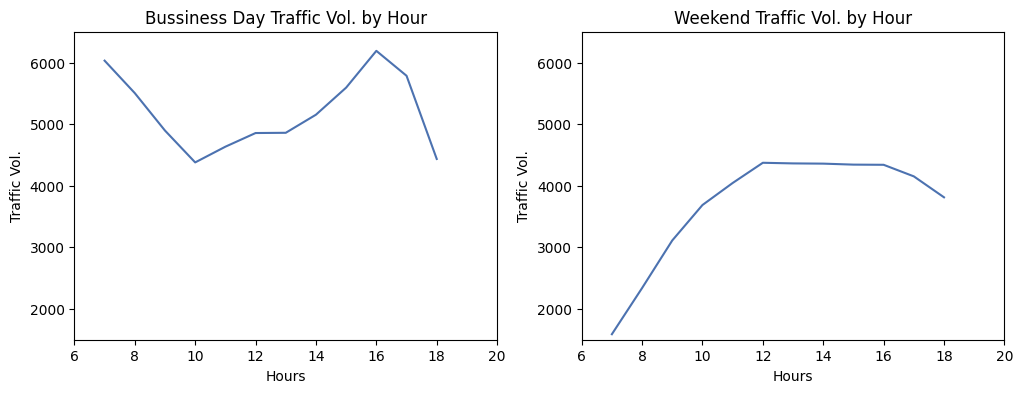

In [502]:
# Plot a line graph to compare hourly business days vs weekend traffic

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
weekdays_hourly_traffic['traffic_volume'].plot.line(xlabel='Hours', ylabel='Traffic Vol.')
plt.title('Bussiness Day Traffic Vol. by Hour')
plt.xlim(6, 20)
plt.ylim(1500,6500)

plt.subplot(1, 2, 2)
weekend_hourly_traffic['traffic_volume'].plot.line(xlabel='Hours', ylabel='Traffic Vol.')
plt.title('Weekend Traffic Vol. by Hour')
plt.xlim(6, 20)
plt.ylim(1500,6500)


**Observations:**
* Business Day: Between 6:30 AM to 6 PM. Rush hours: 5 PM. Decrease at 10 am to 2 PM.
* Weekend Traffic: Peaks during mid-day 12 PM to 4 PM. Almost constant. Not much traffic during early mornings: 6 - 10.

# Closer look at holiday column

i94_traffic['holiday'].value_counts()